Import required modules:

In [1]:
import glob
import torch
import cv2
import numpy as np
from numpy import moveaxis
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
import matplotlib.pyplot as plt
import gc
from PIL import Image
drive.mount('/content/drive')
#torch.cuda.empty_cache()

Mounted at /content/drive


Read data:
  * use map_label to map label image to 2D array of labels per pixle 

In [2]:
def map_label(label):
    colors = [[64,128,64],[192,0,128],[0,128,192],[0,128,64],[128,0,0],[64,0,128],[64,0,192],[192,128,64],[192,192,128],[64,64,128],[128,0,192],[192,0,64],[128,128,64],[192,0,192],[128,64,64],[64,192,128],[64,64,0],[128,64,128],[128,128,192],[0,0,192],[192,128,128],[128,128,128],[64,128,192],[0,0,64],[0,64,64],[192,64,128],[128,128,0],[192,128,192],[64,0,64],[192,192,0],[0,0,0],[64,192,0]]
    out = []
    for c in colors:
      c = np.array(c, dtype = "uint8")
      mask = cv2.inRange(label, c, c)
      out.append(mask)
      #output = cv2.bitwise_and(label, label, mask = mask)
      #mask = [[int(np.sum(r)>0) for r in c] for c in output]
    
    return np.argmax(out,axis = 0)

class Data:
    def __init__(self, file_name):
        self.file_names = glob.glob(file_name)
        self.imgs = []
        self.labels = []
        self.test_imgs = []
        self.test_labels = []
        self.valid_imgs = []
        self.valid_labels = []
        self.train_imgs = []
        self.train_labels = []
        self.test_img = None
        self.test_label = None
    def read(self, begin,end):
        for i in self.file_names[begin:end]:
            img = cv2.resize(cv2.imread(i),(480,360))[:,:,[2,1,0]]
            self.test_img = img
            l = i.replace("/images","/L").replace(".png","") + "_L.png"
            label = cv2.imread(l)[:,:,[2,1,0]]
            self.test_label = label
            label = map_label(cv2.resize(label,(480,360)))
            self.imgs.append(moveaxis(img, 2, 0))
            self.labels.append(label)
    def write(self):
        with open('./drive/MyDrive/camvid/L.txt', 'w') as writefile:
            for i in range(len(self.labels)):
                t = '|'.join(','.join('%0.1f' %x for x in y) for y in self.labels[i])
                t = self.file_names[i] + t
                writefile.write(t)
    def seperate_data(self,test_size):
        index = [i for i in range(len(self.imgs))]
        test_index = np.random.choice(index,test_size*2)
        val_index = test_index[0:test_size]
        test_index = test_index[test_size:-1]
        for i in range(len(self.imgs)):
            if i in test_index:
                self.test_imgs.append(self.imgs[i])
                self.test_labels.append(self.labels[i])
            elif i in val_index:
                self.valid_imgs.append(self.imgs[i])
                self.valid_labels.append(self.labels[i])
            else:
                self.train_imgs.append(self.imgs[i])
                self.train_labels.append(self.labels[i])
        self.test_imgs = np.array(self.test_imgs)
        self.test_labels = np.array(self.test_labels)
        self.valid_imgs = np.array(self.valid_imgs)
        self.valid_labels = np.array(self.valid_labels)
        self.train_imgs = np.array(self.train_imgs)
        self.train_labels = np.array(self.train_labels)
        del self.imgs
        del self.labels

Read data (data address needed):

In [3]:
data = Data('./drive/MyDrive/camvid/images/*.png')

In [4]:
data.read(0,len(data.file_names))

Find mean and var of data:

In [ ]:
'''m = np.mean(data.train_imgs)
std = np.std(data.train_imgs, ddof = 1)'''

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot a sample of images and labels:

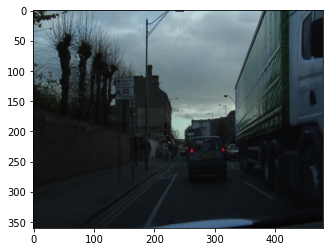

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data.test_img)

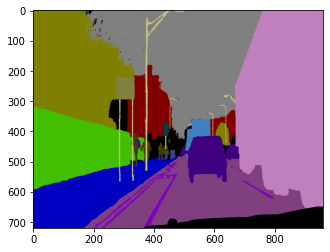

In [ ]:
plt.imshow(data.test_label)

Network modules:
  * Ni: ith encoder decoder set to train seperatly from other encoder/ decoder pairs
  * NT: a network with full encoder decoders to train together

In [5]:
class N1(nn.Module):
    def __init__(self):
        super(N1, self).__init__()
        self.convE = nn.Conv2d(3, 64, kernel_size = 7,padding = 3)
        self.maxpooling = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2,stride = 2)
        self.convD = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.last = nn.Conv2d(64, 32, kernel_size = 1)

    def forward(self, x):
        x = F.relu(self.convE(x))
        downsampled, indices = self.maxpooling(x)
        upsampled = self.unpool(downsampled, indices)
        x = self.convD(upsampled) 
        return self.last(x) #F.softmax(x,dim=1)

class N2(nn.Module):
    def __init__(self,n1):
        super(N2, self).__init__()
        self.convE1 = n1.convE
        self.maxpooling1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE2 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.maxpooling2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool2 = nn.MaxUnpool2d(2,stride = 2)
        self.convD2 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.unpool1 = nn.MaxUnpool2d(2,stride = 2)
        self.convD1 = n1.convD
        self.last = n1.last

    def forward(self, x):
        x = F.relu(self.convE1(x))
        x1, indices1 = self.maxpooling1(x)
        x = F.relu(self.convE2(x1))
        x, indices2 = self.maxpooling2(x)
        x = self.unpool2(x, indices2,output_size=x1.size())
        x = self.convD2(x) 
        x = self.unpool1(x, indices1)
        x = self.convD1(x) 
        return self.last(x) #F.softmax(x,dim=1)
class N3(nn.Module):
    def __init__(self,n2):
        super(N3, self).__init__()
        self.convE1 = n2.convE1
        self.maxpooling1 = n2.maxpooling1
        self.convE2 = n2.convE2
        self.maxpooling2 = n2.maxpooling2
        self.convE3 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.maxpooling3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool3 = nn.MaxUnpool2d(2,stride = 2)
        self.convD3 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.unpool2 = n2.unpool2
        self.convD2 = n2.convD2
        self.unpool1 = n2.unpool1
        self.convD1 = n2.convD1
        self.last = n2.last

    def forward(self, x):
        x = F.relu(self.convE1(x))
        x1, indices1 = self.maxpooling1(x)
        x = F.relu(self.convE2(x1))
        x2, indices2 = self.maxpooling2(x)
        x = F.relu(self.convE3(x2))
        x, indices3 = self.maxpooling3(x)
        x = self.unpool3(x, indices3)
        x = self.convD3(x) 
        x = self.unpool2(x, indices2)
        x = self.convD2(x) 
        x = self.unpool1(x, indices1)
        x = self.convD1(x) 
        return self.last(x) #F.softmax(x,dim=1)
class N4(nn.Module):
    def __init__(self,n3):
        super(N4, self).__init__()
        self.convE1 = n3.convE1
        self.maxpooling1 = n3.maxpooling1
        self.convE2 = n3.convE2
        self.maxpooling2 = n3.maxpooling2
        self.convE3 = n3.convE3
        self.maxpooling3 = n3.maxpooling3
        self.convE4 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.maxpooling4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool4 = nn.MaxUnpool2d(2,stride = 2)
        self.convD4 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.unpool3 = n3.unpool3
        self.convD3 = n3.convD3
        self.unpool2 = n3.unpool2
        self.convD2 = n3.convD2
        self.unpool1 = n3.unpool1
        self.convD1 = n3.convD1
        self.last = n3.last

    def forward(self, x):
        x = F.relu(self.convE1(x))
        x1, indices1 = self.maxpooling1(x)
        x = F.relu(self.convE2(x1))
        x2, indices2 = self.maxpooling2(x)
        x = F.relu(self.convE3(x2))
        x3, indices3 = self.maxpooling3(x)
        x = F.relu(self.convE4(x3))
        x, indices4 = self.maxpooling4(x)
        x = self.unpool4(x, indices4,output_size=x3.size())
        x = self.convD4(x) 
        x = self.unpool3(x, indices3)
        x = self.convD3(x) 
        x = self.unpool2(x, indices2)
        x = self.convD2(x) 
        x = self.unpool1(x, indices1)
        x = self.convD1(x) 
        return self.last(x)


class NT(nn.Module):
    def __init__(self):
        super(NT, self).__init__()
        self.convE1 = nn.Conv2d(3, 64, kernel_size = 7,padding = 3)
        self.maxpooling1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE2 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.maxpooling2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE3 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.maxpooling3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE4 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.maxpooling4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool4 = nn.MaxUnpool2d(2,stride = 2)
        self.convD4 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.unpool3 = nn.MaxUnpool2d(2,stride = 2)
        self.convD3 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.unpool2 = nn.MaxUnpool2d(2,stride = 2)
        self.convD2 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.unpool1 = nn.MaxUnpool2d(2,stride = 2)
        self.convD1 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.last = nn.Conv2d(64, 32, kernel_size = 1)

    def forward(self, x):
        x = F.relu(self.convE1(x))
        x1, indices1 = self.maxpooling1(x)
        x = F.relu(self.convE2(x1))
        x2, indices2 = self.maxpooling2(x)
        x = F.relu(self.convE3(x2))
        x3, indices3 = self.maxpooling3(x)
        x = F.relu(self.convE4(x3))
        x, indices4 = self.maxpooling4(x)
        x = self.unpool4(x, indices4,output_size=x3.size())
        x = self.convD4(x) 
        x = self.unpool3(x, indices3)
        x = self.convD3(x) 
        x = self.unpool2(x, indices2)
        x = self.convD2(x) 
        x = self.unpool1(x, indices1)
        x = self.convD1(x) 
        return self.last(x)


Creating mini batches of data (use index only to prevent RAM problems):

In [6]:
def creat_minibatch(l):
    merged = [ i for i in range(l) ] 
    np.random.shuffle(merged)
    batchX = []
    batchy = []
    i = 0
    while i < len(merged):
        x = merged[i:i+batch_size]
        y = merged[i:i+batch_size]
        batchX.append(x)
        batchy.append(y)
        i = i + batch_size
    return batchX, batchy

Separat data:

In [7]:
data.seperate_data(100)

### Train all layers together no batch regularization:

In [ ]:
n4 = NT()
if False:
    n4.load_state_dict(torch.load('./drive/MyDrive/camvid/nT_p'))
    n4.eval()
n4.cuda()
optimizer = optim.SGD(n4.parameters(), lr=0.01, momentum=0.9)
losslog4 = []
testloss4 = []
batch_size = 10
for i in range(10):
    l = []
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    gc.collect()
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for i in range(4):
            optimizer.zero_grad()
            out = n4(torch.Tensor(data.train_imgs[x_batch]).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out, torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n4.zero_grad()
            output.backward()
            optimizer.step()    
        l.append(np.mean(l1))
        #print(l[-1])    
    losslog4.append(np.mean(l))
    print("mean:"+str(losslog4[-1]))
    temp = []
    for i in range(10):
        out = n4(torch.Tensor(data.test_imgs[i:i+10]).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss4.append(np.mean(temp))
torch.save(n4.state_dict(), './drive/MyDrive/camvid/nT_p')

mean:2.41257887122766
mean:2.112981156358179
mean:1.89826053156043
mean:1.7495002240504858
mean:1.564865451938701
mean:1.3584779141084202
mean:1.2834779980047695
mean:1.211031160545799
mean:1.115368886376327
mean:1.0555971371677686


In [ ]:
n4 = NT()
if True:
    n4.load_state_dict(torch.load('./drive/MyDrive/camvid/nT_p'))
    n4.eval()
n4.cuda()
optimizer = optim.SGD(n4.parameters(), lr=0.01, momentum=0.9)
losslog4 = []
testloss4 = []
batch_size = 10
for i in range(10):
    l = []
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    gc.collect()
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for i in range(4):
            optimizer.zero_grad()
            out = n4(torch.Tensor(data.train_imgs[x_batch]).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out, torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n4.zero_grad()
            output.backward()
            optimizer.step()    
        l.append(np.mean(l1))
        #print(l[-1])    
    losslog4.append(np.mean(l))
    print("mean:"+str(losslog4[-1]))
    temp = []
    for i in range(10):
        out = n4(torch.Tensor(data.test_imgs[i:i+10]).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss4.append(np.mean(temp))
torch.save(n4.state_dict(), './drive/MyDrive/camvid/nT_p')

mean:0.9200883988501891
mean:0.8736498547050188
mean:0.8224861391310422
mean:0.7853885948095681
mean:0.7421080880569961
mean:0.7595737688946274
mean:0.6826967088119039
mean:0.6500903010930655
mean:0.6262686924552018
mean:0.5999075933447424


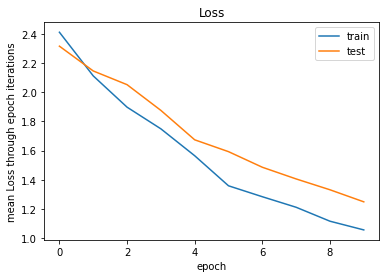

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog4,label="train")
plt.plot([i for i in range(10)],testloss4,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss")
plt.legend()
plt.show()

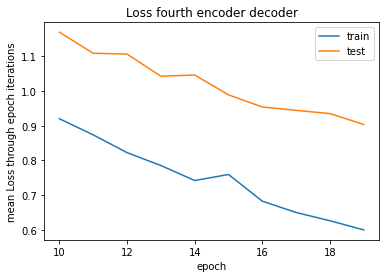

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i+10 for i in range(10)],losslog4,label="train")
plt.plot([i+10 for i in range(10)],testloss4,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss fourth encoder decoder")
plt.legend()
plt.show()

Read pre-trained network:

In [29]:
n4 = NT()
n4.load_state_dict(torch.load('./drive/MyDrive/camvid/nT_p2'))
n4.eval()
n4.cuda()

NT(
  (convE1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convE2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convE3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convE4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpooling4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool4): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (convD4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (unpool3): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (convD3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (unpool

Test model:

In [9]:
test = n4(torch.Tensor(data.test_imgs[0:10]).cuda())
test = [np.argmax(t.cpu().detach().numpy() ,axis = 0) for t in test]

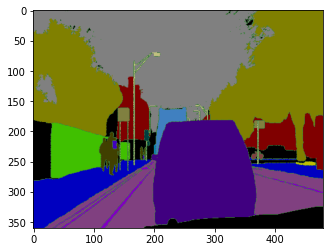

In [ ]:
colors = [[64,128,64],[192,0,128],[0,128,192],[0,128,64],[128,0,0],[64,0,128],[64,0,192],[192,128,64],[192,192,128],[64,64,128],[128,0,192],[192,0,64],[128,128,64],[192,0,192],[128,64,64],[64,192,128],[64,64,0],[128,64,128],[128,128,192],[0,0,192],[192,128,128],[128,128,128],[64,128,192],[0,0,64],[0,64,64],[192,64,128],[128,128,0],[192,128,192],[64,0,64],[192,192,0],[0,0,0],[64,192,0]]
plt.imshow([[colors[c] for c in r] for r in data.test_labels[7]])

Test after 10 epoch:

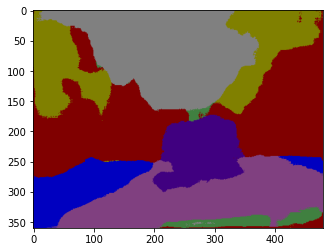

In [ ]:
colors = [[64,128,64],[192,0,128],[0,128,192],[0,128,64],[128,0,0],[64,0,128],[64,0,192],[192,128,64],[192,192,128],[64,64,128],[128,0,192],[192,0,64],[128,128,64],[192,0,192],[128,64,64],[64,192,128],[64,64,0],[128,64,128],[128,128,192],[0,0,192],[192,128,128],[128,128,128],[64,128,192],[0,0,64],[0,64,64],[192,64,128],[128,128,0],[192,128,192],[64,0,64],[192,192,0],[0,0,0],[64,192,0]]
plt.imshow([[colors[c] for c in r] for r in test])

Test after 20 epoch:

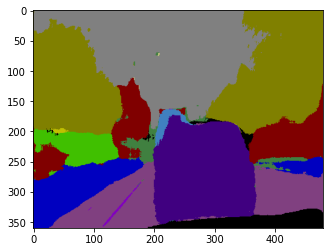

In [ ]:
colors = [[64,128,64],[192,0,128],[0,128,192],[0,128,64],[128,0,0],[64,0,128],[64,0,192],[192,128,64],[192,192,128],[64,64,128],[128,0,192],[192,0,64],[128,128,64],[192,0,192],[128,64,64],[64,192,128],[64,64,0],[128,64,128],[128,128,192],[0,0,192],[192,128,128],[128,128,128],[64,128,192],[0,0,64],[0,64,64],[192,64,128],[128,128,0],[192,128,192],[64,0,64],[192,192,0],[0,0,0],[64,192,0]]
plt.imshow([[colors[c] for c in r] for r in test[7]])

randomly test model after 20 epochs:

In [ ]:
index = np.random.choice(len(data.test_imgs),4)
test = n4(torch.Tensor(data.test_imgs[index]).cuda())
test = [np.argmax(t.cpu().detach().numpy() ,axis = 0) for t in test]

<Figure size 432x288 with 0 Axes>

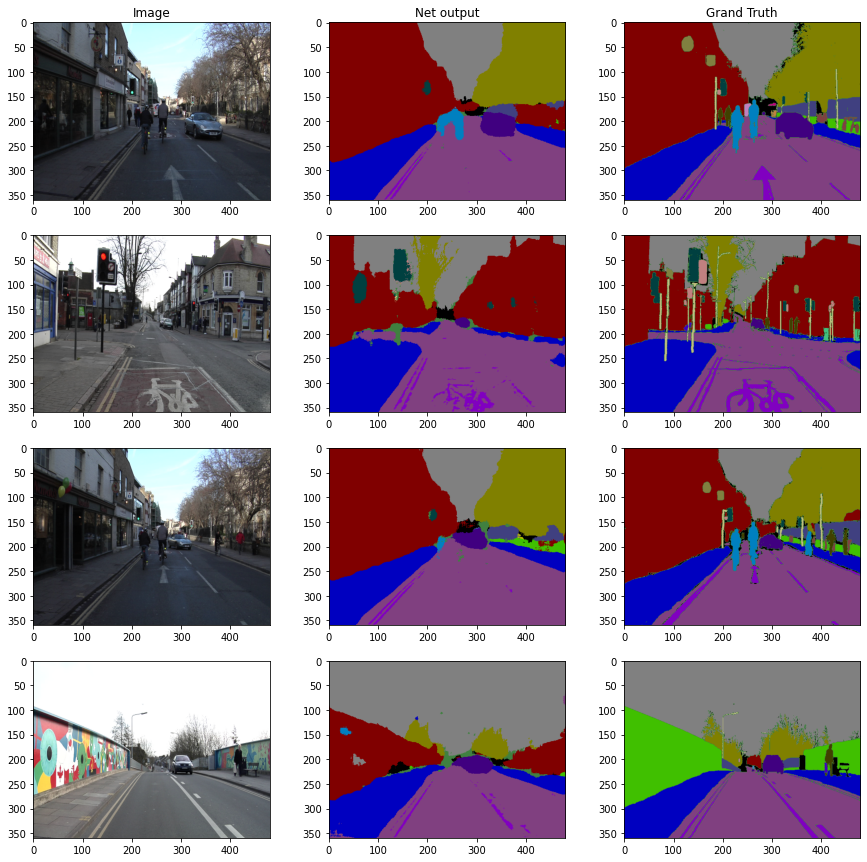

In [ ]:
plt.figure()
f, axarr = plt.subplots(4,3,figsize=(15,15)) 
axarr[0,0].title.set_text('Image')
axarr[0,1].title.set_text('Net output')
axarr[0,2].title.set_text('Grand Truth')
for i in range(4):
    axarr[i,0].imshow(moveaxis(data.test_imgs[index[i]], 0, 2))
    axarr[i,1].imshow([[colors[c] for c in r] for r in test[i]])
    axarr[i,2].imshow([[colors[c] for c in r] for r in data.test_labels[index[i]]])

### Using batch norm:

In [32]:
class NTBN(nn.Module):
    def __init__(self):
        super(NTBN, self).__init__()
        self.convE1 = nn.Conv2d(3, 64, kernel_size = 7,padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpooling1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE2 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpooling2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE3 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpooling3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.convE4 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpooling4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool4 = nn.MaxUnpool2d(2,stride = 2)
        self.convD4 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn5 = nn.BatchNorm2d(64)
        self.unpool3 = nn.MaxUnpool2d(2,stride = 2)
        self.convD3 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn6 = nn.BatchNorm2d(64)
        self.unpool2 = nn.MaxUnpool2d(2,stride = 2)
        self.convD2 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn7 = nn.BatchNorm2d(64)
        self.unpool1 = nn.MaxUnpool2d(2,stride = 2)
        self.convD1 = nn.Conv2d(64, 64, kernel_size = 7,padding = 3)
        self.bn8 = nn.BatchNorm2d(64)
        self.last = nn.Conv2d(64, 32, kernel_size = 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.convE1(x)))
        x1, indices1 = self.maxpooling1(x)
        x = F.relu(self.bn2(self.convE2(x1)))
        x2, indices2 = self.maxpooling2(x)
        x = F.relu(self.bn3(self.convE3(x2)))
        x3, indices3 = self.maxpooling3(x)
        x = F.relu(self.bn4(self.convE4(x3)))
        x, indices4 = self.maxpooling4(x)
        x = self.unpool4(x, indices4,output_size=x3.size())
        x = self.bn5(self.convD4(x)) 
        x = self.unpool3(x, indices3)
        x = self.bn6(self.convD3(x)) 
        x = self.unpool2(x, indices2)
        x = self.bn7(self.convD2(x)) 
        x = self.unpool1(x, indices1)
        x = self.bn8(self.convD1(x)) 
        return self.last(x)


In [ ]:
n4 = NTBN()
if False:
    n4.load_state_dict(torch.load('./drive/MyDrive/camvid/nTbn'))
    n4.eval()
n4.cuda()
optimizer = optim.SGD(n4.parameters(), lr=0.01, momentum=0.9)
losslog4 = []
testloss4 = []
batch_size = 10
for i in range(20):
    l = []
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    gc.collect()
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for i in range(4):
            optimizer.zero_grad()
            out = n4(torch.Tensor(data.train_imgs[x_batch]).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out, torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n4.zero_grad()
            output.backward()
            optimizer.step()    
        l.append(np.mean(l1))
        #print(l[-1])    
    losslog4.append(np.mean(l))
    print("mean:"+str(losslog4[-1]))
    temp = []
    for i in range(10):
        out = n4(torch.Tensor(data.test_imgs[i:i+10]).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss4.append(np.mean(temp))
torch.save(n4.state_dict(), './drive/MyDrive/camvid/nTbn2')

mean:1.4803659468889236
mean:1.1619270893762697
mean:0.9989382084810509
mean:0.9101249584049549
mean:0.8487716772646274
mean:0.787161999153641
mean:0.748002420618849
mean:0.716183344710548
mean:0.6791061081413953
mean:0.6536577625094719
mean:0.640432782049449
mean:0.6128213717690054
mean:0.5991541781234291
mean:0.5875565231127559
mean:0.5762392780128515
mean:0.5692798820025516
mean:0.5415439002637593
mean:0.5362774497776661
mean:0.532003382748028
mean:0.5051136348607406


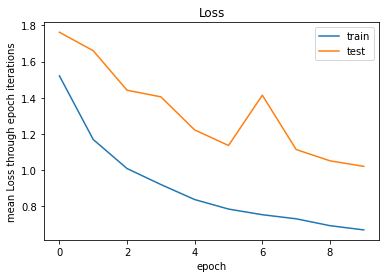

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog4,label="train")
plt.plot([i for i in range(10)],testloss4,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss")
plt.legend()
plt.show()

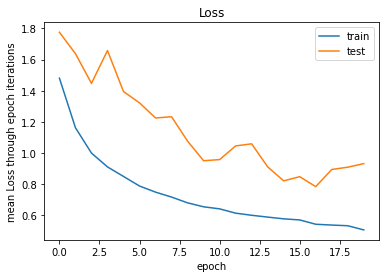

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(20)],losslog4,label="train")
plt.plot([i for i in range(20)],testloss4,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss")
plt.legend()
plt.show()

In [33]:
n4 = NTBN()
n4.load_state_dict(torch.load('./drive/MyDrive/camvid/nTbn2'))
n4.eval()
n4.cuda()

NTBN(
  (convE1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convE2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convE3): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convE4): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling4): MaxPool2d(kernel_size=2, stride=2,

<Figure size 432x288 with 0 Axes>

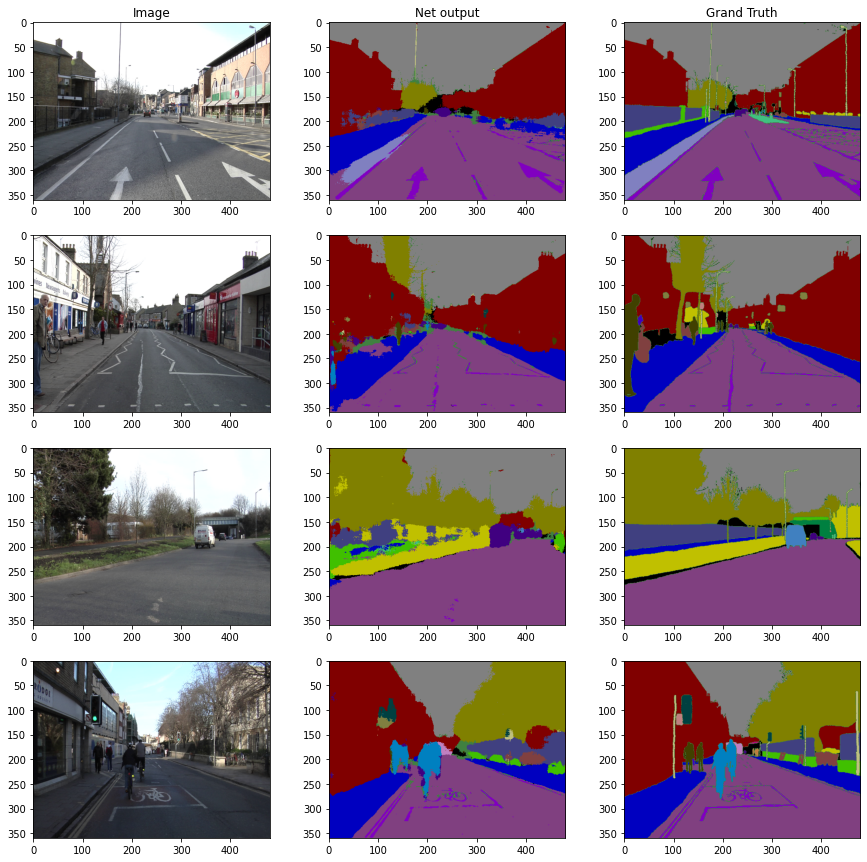

In [ ]:
index = np.random.choice(len(data.test_imgs),4)
test = n4(torch.Tensor(data.test_imgs[index]).cuda())
test = [np.argmax(t.cpu().detach().numpy() ,axis = 0) for t in test]
plt.figure()
f, axarr = plt.subplots(4,3,figsize=(15,15)) 
axarr[0,0].title.set_text('Image')
axarr[0,1].title.set_text('Net output')
axarr[0,2].title.set_text('Grand Truth')
for i in range(4):
    axarr[i,0].imshow(moveaxis(data.test_imgs[index[i]], 0, 2))
    axarr[i,1].imshow([[colors[c] for c in r] for r in test[i]])
    axarr[i,2].imshow([[colors[c] for c in r] for r in data.test_labels[index[i]]])

### Train separatly:
(need to be trained more epochs than 10 or 20 and more times for each bach than 4 times for each encoder/decor)

In [ ]:
n1 = N1()
if True:
    n1.load_state_dict(torch.load('./drive/MyDrive/camvid/n1'))
    n1.eval()
n1.cuda()

optimizer = optim.SGD(n1.parameters(), lr=0.01, momentum=0.9)
losslog = []
testloss = []
batch_size = 10
for i in range(10):
    l = []
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    gc.collect()
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for i in range(4):
            optimizer.zero_grad()
            out = n1(torch.Tensor(data.train_imgs[x_batch]).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out ,  torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n1.zero_grad()
            output.backward()
            optimizer.step()
        l.append(np.mean(l1))
    losslog.append(np.mean(l))
    print("mean:"+str(losslog[-1]))
    temp = []
    for i in range(10):
        out = n1(torch.Tensor(data.test_imgs[i:i+10]).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss.append(np.mean(temp))
torch.save(n1.state_dict(), './drive/MyDrive/camvid/n1')

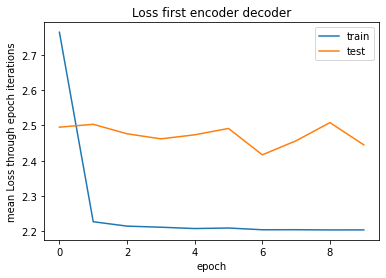

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog,label="train")
plt.plot([i for i in range(10)],testloss,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss first encoder decoder")
plt.legend()
plt.show()

In [ ]:
n1 = N1()
n1.load_state_dict(torch.load('./drive/MyDrive/camvid/n1'))
n1.eval()

N1(
  (convE): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (convD): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (last): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
)

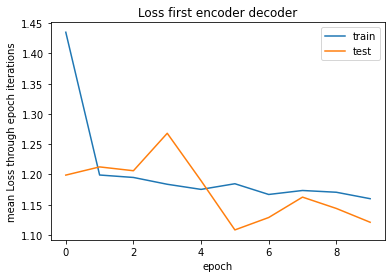

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog,label="train")
plt.plot([i for i in range(10)],testloss,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss first encoder decoder")
plt.legend()
plt.show()

In [ ]:
n2 = N2(n1)
if True:
    n2.load_state_dict(torch.load('./drive/MyDrive/camvid/n2'))
    n2.eval()
n2.cuda()
optimizer = optim.SGD(n2.parameters(), lr=0.1, momentum=0.9)
for param in n2.convE1.parameters():
    param.requires_grad = False
for param in n2.convD1.parameters():
    param.requires_grad = False
for param in n2.last.parameters():
    param.requires_grad = False
#optimizer2 = optim.SGD(n2.convD2.parameters(), lr=0.01, momentum=0.9)
losslog2 = []
testloss2 = []
batch_size = 8
for i in range(10):
    l = []
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    gc.collect()
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for j in range(4):
            optimizer.zero_grad()
            #optimizer2.zero_grad()
            out = n2(torch.Tensor(data.train_imgs[x_batch]).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out, torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n2.zero_grad()
            output.backward()
            optimizer.step()    
            #optimizer2.step()  
        l.append(np.mean(l1))  
    losslog2.append(np.mean(l))
    print(losslog2[-1])
    temp = []
    for i in range(10):
        out = n2(torch.Tensor(data.test_imgs[i:i+10]).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss2.append(np.mean(temp))
torch.save(n2.state_dict(), './drive/MyDrive/camvid/n2')

10657.212721044367


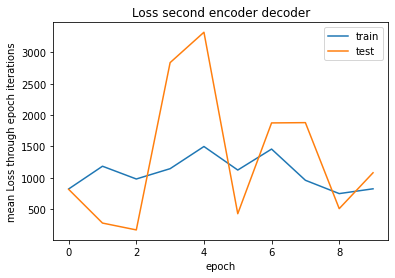

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog2,label="train")
plt.plot([i for i in range(10)],testloss2,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss second encoder decoder")
plt.legend()
plt.show()

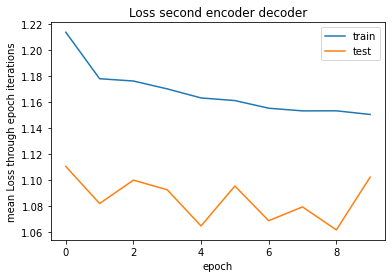

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog2,label="train")
plt.plot([i for i in range(10)],testloss2,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss second encoder decoder")
plt.legend()
plt.show()

In [ ]:
n2 = N2(n1)
n2.load_state_dict(torch.load('./drive/MyDrive/camvid/n2'))
n2.eval()

In [ ]:
n3 = N3(n2)
if False:
    n3.load_state_dict(torch.load('./drive/MyDrive/camvid/n3'))
    n3.eval()
n3.cuda()
optimizer = optim.SGD(n3.convE3.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(n3.convD3.parameters(), lr=0.01, momentum=0.9)
losslog3 = []
testloss3 = []
batch_size = 8
for i in range(10):
    l = []
    gc.collect()
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for i in range(2):
            optimizer.zero_grad()
            optimizer2.zero_grad()
            out = n3(torch.Tensor((data.train_imgs[x_batch]-m)/std).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out, torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n3.zero_grad()
            output.backward()
            optimizer.step()    
            optimizer2.step()    
        l.append(np.mean(l1))
    losslog3.append(np.mean(l))
    temp = []
    for i in range(10):
        out = n3(torch.Tensor((data.test_imgs[i:i+10]-m)/std).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss3.append(np.mean(temp))
torch.save(n3.state_dict(), './drive/MyDrive/camvid/n3')

In [ ]:
print(losslog3)

[1.1694653510157742, 1.149597108808916, 1.1394617272846734, 1.1359409405224359, 1.1275061026437958, 1.1266975905468215, 1.123895336442919, 1.1173655488597813, 1.1164301375844585, 1.1125322086597556]


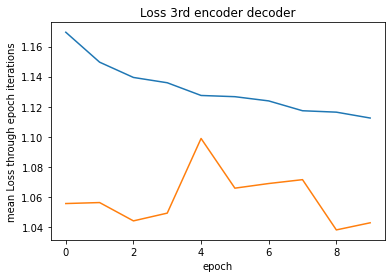

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog3,label="train")
plt.plot([i for i in range(10)],testloss3,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss 3rd encoder decoder")
plt.show()

In [ ]:
n3 = N3(n2)
n3.load_state_dict(torch.load('./drive/MyDrive/camvid/n3'))
n3.eval()

In [ ]:
n4 = N4(n3)
if False:
    n4.load_state_dict(torch.load('./drive/MyDrive/camvid/n4'))
    n4.eval()
n4.cuda()
optimizer = optim.SGD(n4.convE4.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(n4.convD4.parameters(), lr=0.01, momentum=0.9)
losslog4 = []
testloss4 = []
batch_size = 10
for i in range(10):
    l = []
    batchX, batchy = creat_minibatch(len(data.train_imgs))
    gc.collect()
    for (x_batch,y_batch) in zip(batchX, batchy):
        l1 = []
        for i in range(2):
            optimizer.zero_grad()
            optimizer2.zero_grad()
            out = n4(torch.Tensor(data.train_imgs[x_batch]).cuda())
            loss = nn.CrossEntropyLoss()
            output = loss(out, torch.Tensor(data.train_labels[y_batch]).long().cuda())
            l1.append(float(output))
            n4.zero_grad()
            output.backward()
            optimizer.step()    
            optimizer2.step()
        l.append(np.mean(l1))    
    losslog4.append(np.mean(l))
    temp = []
    for i in range(10):
        out = n4(torch.Tensor((data.test_imgs[i:i+10]-m)/std).cuda())
        temp.append(float(loss(out, torch.Tensor(data.test_labels[i:i+10]).long().cuda())))
    testloss4.append(np.mean(temp))
torch.save(n4.state_dict(), './drive/MyDrive/camvid/n4')

In [ ]:
print(losslog4)

[1.562281413210763, 1.2109580768479242, 1.2217853643276073, 1.2096308745719768, 1.208956778049469, 1.2069660656981998, 1.2088211101514321, 1.204275483334506, 1.2065445615185633, 1.208533854396255]


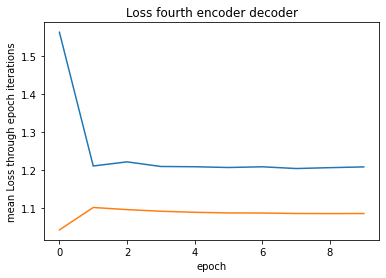

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(10)],losslog4,label="train")
plt.plot([i for i in range(10)],testloss4,label="test")
plt.xlabel("epoch")
plt.ylabel("mean Loss through epoch iterations")
plt.title("Loss fourth encoder decoder")
plt.show()